In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir

sns.set(style="ticks", font_scale=1.2, font="Arial")

# Plotting constants

In [2]:
MODEL_MAP = {
    "google/gemma-2b": "Gemma 2B",
    "google/gemma-7b": "Gemma 7B",
    "mistralai/Mistral-7B-v0.1": "Mistral 7B",
    "allenai/OLMo-1B": "OLMo 1B",
    "allenai/OLMo-7B": "OLMo 7B",
    "meta-llama/Llama-2-7b-hf": "Llama-2 7B",
    "meta-llama/Llama-2-13b-hf": "Llama-2 13B",
    "meta-llama/Llama-2-70b-hf": "Llama-2 70B",
    "EleutherAI/pythia-1b-deduped": "Pythia 1B",
    "EleutherAI/pythia-1.4b-deduped": "Pythia 1.4B",
    "EleutherAI/pythia-2.8b-deduped": "Pythia 2.8B",
    "EleutherAI/pythia-6.9b-deduped": "Pythia 6.9B",
    "EleutherAI/pythia-12b-deduped": "Pythia 12B",
}
MODEL_ORDER = [
    "OLMo 1B",
    "OLMo 7B",
    "Pythia 1B",
    "Pythia 1.4B",
    "Pythia 2.8B",
    "Pythia 6.9B",
    "Pythia 12B",
    "Llama-2 7B",
    "Llama-2 13B",
    "Llama-2 70B",
    "Gemma 2B",
    "Gemma 7B",
    "Mistral 7B"
]

# Model-related settings and helper functions.
def get_base_model(model):
    return model.split(" ")[0]
MODEL_FAMILY_ORDER = ["Pythia", "OLMo", "Gemma", "Llama-2", "Mistral"]
MODEL_FAMILY_PALETTE_NAMES = {
    model_family: pal_name
    for model_family, pal_name in zip(MODEL_FAMILY_ORDER, ["Blues", "Reds", "Greens", "Purples", "Oranges"])
}
MODEL_MARKERS = ["o", "v", "p", "D", "s", "^"]
def get_pretty_model_name(row):
    if row.model in MODEL_MAP:
        return MODEL_MAP[row.model]
    else:
        return row.model
def get_n_params(model_name, in_billions=True):
    n_param_str = model_name.split()[1]
    multiplier = n_param_str[-1] # "M" or "B"
    assert multiplier in ["M", "B"]
    n_params = eval(n_param_str[:-1])
    if multiplier == "M":
        if in_billions:
            return n_params * 0.001
        else:
            return n_params * 1e6
    else:
        return n_params if in_billions else n_params * 1e9
    
# Evaluation-related settings and helper functions.
EVAL_MAP = {
    "generated": "Production",
    "mc": "Forced choice",
    "direct": "Direct",
    "meta": "Metalinguistic"
}
LOW_DEMAND_COLOR = "#A7D0CD"
HIGH_DEMAND_COLOR = "#DE8971"
EVAL_PAL = [LOW_DEMAND_COLOR, HIGH_DEMAND_COLOR]
def get_eval_order(domain):
    if domain in ["crt", "digit_mat"]:
        LOW_DEMAND_METHOD = "Forced choice"
        HIGH_DEMAND_METHOD = "Production"
    elif domain in ["lambada", "syntax"]:
        LOW_DEMAND_METHOD = "Direct"
        HIGH_DEMAND_METHOD = "Metalinguistic"
    else:
        raise ValueError(f"Unknown eval order for domain={domain}")
    eval_order = [LOW_DEMAND_METHOD, HIGH_DEMAND_METHOD]
    return eval_order

def render(outpath):
    plt.savefig(f"../figures/{outpath}", bbox_inches="tight", dpi=300)
    print(f"Saved figure to ../figures/{outpath}")

# Plotting functions

In [3]:
def plot_metric_by_eval(df_long, eval_order, metric, label=None, chance=None):
    width_ratios = [
        df_long[df_long.model_family==m].model.nunique() 
        for m in MODEL_FAMILY_ORDER
    ]
    fig, axes = plt.subplots(nrows=1, ncols=len(MODEL_FAMILY_ORDER), sharey=True,
                             width_ratios=width_ratios)
    
    for i, ax in enumerate(axes):
        model_family = MODEL_FAMILY_ORDER[i]
        data = df_long[df_long.model_family==model_family]
        model_order = [m for m in MODEL_ORDER if m in data.model.unique()]
        ax = sns.barplot(
            data=data,
            x="model",
            order=model_order,
            y=metric,
            hue="pretty_eval_method",
            hue_order=eval_order,
            palette=EVAL_PAL,
            err_kws={'linewidth': 1},
            ax=ax
        )
        # Title.
        ax.set_title(model_family)

        # Chance.
        if chance is not None:
            ax.axhline(chance, linestyle="--", color="k", alpha=0.5)

        # X-axis.
        ax.set_xlabel("")
        xticks = ax.get_xticks()
        xticklabels = ax.get_xticklabels()
        sizes = [x.get_text().split(" ")[1] for x in xticklabels]
        ax.set_xticks(xticks)
        ax.set_xticklabels(sizes)
        
        # Legend and ylabel.
        ax.legend().remove()
        if i == 0:
            if label is None:
                label = metric
            ax.set_ylabel(label)
        else:
            ax.set_ylabel("")

    # Figure-level legend.
    handles, labels = ax.get_legend_handles_labels()
    labels = [labels[0] + " (Low task demands)", labels[1] + " (High task demands)"]
    plt.figlegend(handles[:2], labels, title="", ncol=2, loc="lower center", bbox_to_anchor=(0.5, 1), frameon=False)

    # Figure-level xlabel.
    fig.text(0.5, -0.1, "Model size", ha='center')

    # Aesthetics.
    fig.set_size_inches(9,2.5)
    sns.despine()

In [4]:
def compute_log_odds(df_long, eval_order, metric="response_correct"):
    # Compute proportion correct for each model and evaluation method.
    g = df_long.groupby(["model", "model_family", "model_n_params", "pretty_eval_method"])[metric].mean().rename("proportion_correct").to_frame().reset_index()
    # Compute log odds.
    g["odds"] = g["proportion_correct"] / (1 - g["proportion_correct"])
    g["log_odds"] = np.log(g["odds"])
    low_demand_method, high_demand_method = eval_order
    high_demand = g[g.pretty_eval_method==high_demand_method].set_index(["model", "model_family", "model_n_params"]).log_odds
    low_demand = g[g.pretty_eval_method==low_demand_method].set_index(["model", "model_family", "model_n_params"]).log_odds
    log_odds_diff = (low_demand - high_demand).rename("log_odds_diff").to_frame().reset_index()
    
    return log_odds_diff

In [5]:
def plot_metric_vs_size(df_wide, metric, label=None, logscale=True):
    df_wide["model_n_params_log"] = np.log10(df_wide.model_n_params)
    param_metric = "model_n_params_log" if logscale else "model_n_params"
    means = df_wide.groupby(["model", "model_family", param_metric])[metric].mean().reset_index()

    ax = plt.gca()
    for i, model_family in enumerate(MODEL_FAMILY_ORDER):
        pal = sns.color_palette(MODEL_FAMILY_PALETTE_NAMES[model_family])
        ax = sns.scatterplot(
            data=means[means.model_family==model_family],
            x=param_metric,
            y=metric,
            marker=MODEL_MARKERS[i],
            color=pal[2],
            s=100,
            ax=ax,
            zorder=5
        )
        ax = sns.regplot(
            data=means[means.model_family==model_family],
            x=param_metric,
            y=metric,
            ci=None,
            scatter=False,
            color=pal[2],
        )
        ax.legend().remove()
        
    
    ax = sns.regplot(
        data=means,
        x=param_metric,
        y=metric,
        scatter=False,
        color="silver",
        ax=ax
    )
    ax = sns.regplot(
        data=means,
        x=param_metric,
        y=metric,
        ci=None,
        scatter=False,
        color="k",
        ax=ax
    )
    
    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D(
            [0], [0], 
            marker=MODEL_MARKERS[i], 
            label=model_family, 
            color=sns.color_palette(MODEL_FAMILY_PALETTE_NAMES[model_family])[2], 
            markersize=8, 
            linestyle='None'
        )
        for i, model_family in enumerate(MODEL_FAMILY_ORDER)
    ]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.9, 0.5), frameon=False, handletextpad=0.1)

    # Axis labels.
    if logscale:
        xlabel = "# parameters\n(log billions)"
    else:
        xlabel = "# parameters (billions)"
    ax.set_xlabel(xlabel)
    if label is None:
        label = metric
    ax.set_ylabel(label)
        
    # Aesthetics.
    plt.gcf().set_size_inches(2.5, 3.2)
    sns.despine()

# Analogical reasoning (digit matrices)

In [6]:
def read_results(task="digit_mat"): 
    folder=f"../output/{task}"
    files = listdir(folder)
    df_wide = pd.concat([pd.read_csv(f"{folder}/{f}") for f in files if f.endswith(".csv") and "step" not in f])
    df_wide = df_wide[df_wide.model.isin(MODEL_MAP.keys())]
    # Set some variables.
    df_wide.model = df_wide.apply(get_pretty_model_name, axis=1)
    df_wide = df_wide[~df_wide.model.isna()]
    df_wide["model_family"] = df_wide.model.apply(get_base_model)
    df_wide["model_n_params"] = df_wide.model.apply(get_n_params, in_billions=True)

    # Convert wide to long format.
    data_long = []
    meta_vars = ["model", "model_family", "model_n_params", "problem_type", "problem_ind", "problem_id"]
    if task == "digit_mat":
        meta_vars += ["perm_invariant", "correct_answer"]
    else:
        meta_vars += ["prompt", "correct_answer", "foil"]
    for _, row in df_wide.iterrows():
        for eval_method in ["generated", "mc"]:
            # Copy meta-information about this stimulus item.
            res = {v: row[v] for v in meta_vars}
            # Add specific information about responses.
            res.update({
                "response": row[f"{eval_method}_response"],
                "response_sum_logprob": row[f"{eval_method}_response_sum_logprob"],
                "response_correct": row[f"{eval_method}_response_correct"],
                "eval_method": eval_method,
                "pretty_eval_method": EVAL_MAP[eval_method]
            })
            data_long.append(res)
    df_long = pd.DataFrame(data_long)
    return df_wide, df_long

domain = "digit_mat"
eval_order = get_eval_order(domain)
low_demand_method, high_demand_method = eval_order
df_wide, df_long = read_results(task=domain)
df_wide.to_csv(f"processed_data/{domain}_wide_size.csv", index=False)
df_long.to_csv(f"processed_data/{domain}_long_size.csv", index=False)
df_wide.head()

,problem_type,problem_ind,problem_id,perm_invariant,correct_answer,generated_response,generated_response_sum_logprob,generated_response_pred_set,generated_response_correct,mc_answer_logprobs,mc_response_index,mc_response,mc_response_sum_logprob,mc_response_correct,model,revision,model_family,model_n_params
0,row_constant,0,row_constant_0,False,[3],3]\n[4] [4] [,-1.603971,[3],True,"[-7.576299667358398, -6.581323623657227, -6.34...",3,3],-0.043171,True,Llama-2 7B,NaN,Llama-2,7.0
1,col_constant,0,col_constant_0,False,[6],6]\n[1] [7] [,-0.519374,[6],True,"[-5.363811492919922, -5.645761489868164, -5.86...",6,6],-0.054522,True,Llama-2 7B,NaN,Llama-2,7.0
2,dist3_diag1,0,dist3_diag1_0,False,[2],2]\n[6] [2] [,-2.577343,[2],True,"[-0.5228557586669922, -2.717256546020508, -3.0...",0,2],-0.522856,True,Llama-2 7B,NaN,Llama-2,7.0
3,dist3_diag2,0,dist3_diag2_0,False,[9],9]\n[9] [6] [,-2.379793,[9],True,"[-5.069478988647461, -5.202029228210449, -6.54...",5,9],-0.173119,True,Llama-2 7B,NaN,Llama-2,7.0
4,prog_size1,0,prog_size1_0,False,[4],4]\n[3] [4] [,-0.342949,[4],True,"[-6.4116716384887695, -8.508148193359375, -6.3...",4,4],-0.013283,True,Llama-2 7B,NaN,Llama-2,7.0


In [7]:
log_odds_diff = compute_log_odds(df_long, eval_order)
log_odds_diff

,model,model_family,model_n_params,log_odds_diff
0,Gemma 2B,Gemma,2.0,0.526905
1,Gemma 7B,Gemma,7.0,0.204013
2,Llama-2 13B,Llama-2,13.0,0.536023
3,Llama-2 70B,Llama-2,70.0,0.357115
4,Llama-2 7B,Llama-2,7.0,0.634000
5,Mistral 7B,Mistral,7.0,0.328892
6,OLMo 1B,OLMo,1.0,0.777068
7,OLMo 7B,OLMo,7.0,0.556693
8,Pythia 1.4B,Pythia,1.4,0.534037
9,Pythia 12B,Pythia,12.0,0.498512


Saved figure to ../figures/digit_mat_accuracy.pdf


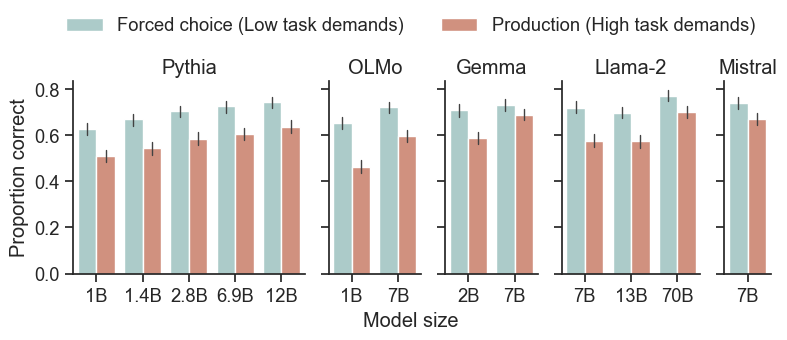

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved figure to ../figures/digit_mat_log_odds_by_size.pdf


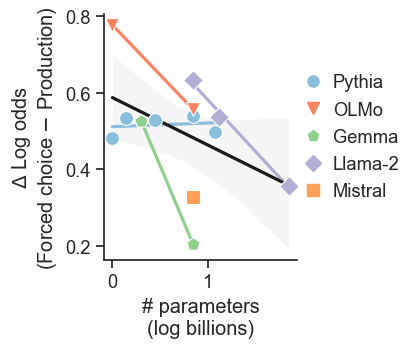

In [8]:
plot_metric_by_eval(df_long, eval_order, "response_correct", "Proportion correct")
render(f"{domain}_accuracy.pdf")
plt.show()
plt.clf()
plot_metric_vs_size(log_odds_diff, "log_odds_diff", label=f"$\\Delta$ Log odds\n({low_demand_method} $-$ {high_demand_method})")
render(f"{domain}_log_odds_by_size.pdf")

# Reflective reasoning (cognitive reflection tests)

In [9]:
def read_results(task="crt", condition="crt1"): 
    folder=f"../output/{task}/{condition}"
    files = listdir(folder)
    df_wide = pd.concat([pd.read_csv(f"{folder}/{f}") for f in files if f.endswith(".csv")])

    # Set some variables.
    df_wide["condition"] = condition
    df_wide.model = df_wide.apply(get_pretty_model_name, axis=1)
    df_wide = df_wide[~df_wide.model.isna()]
    df_wide["model_family"] = df_wide.model.apply(get_base_model)
    df_wide["model_n_params"] = df_wide.model.apply(get_n_params)
    df_wide["mc_correct_gt_intuitive"] = df_wide.apply(
        lambda r: (r.mc_correct_logprob > r.mc_intuitive_logprob),
        axis=1
    )
    df_wide["generated_response_correct"] = (df_wide["generated_response_label"] == "correct")
    
    # Convert wide to long format.
    data_long = []
    meta_vars = ["condition", "model", "model_family", "model_n_params", "item_id", "question"]

    for _, row in df_wide.iterrows():
        for eval_method in ["generated", "mc"]:
            # Copy meta-information about this stimulus item.
            res = {v: row[v] for v in meta_vars}
            # Add specific information about responses.
            res.update({
                "response": row[f"{eval_method}_response"],
                "response_label": row[f"{eval_method}_response_label"],
                "response_correct": row["mc_correct_gt_intuitive"] if eval_method == "mc" else row["generated_response_correct"],
                "eval_method": eval_method,
                "pretty_eval_method": EVAL_MAP[eval_method]
            })
            data_long.append(res)
    df_long = pd.DataFrame(data_long)
    return df_wide, df_long

domain = "crt"
eval_order = get_eval_order(domain)
low_demand_method, high_demand_method = eval_order
wide, long = [], []
for condition in ["crt1", "crt2", "crt3"]:
    df_wide, df_long = read_results(task=domain, condition=condition)
    wide.append(df_wide)
    long.append(df_long)
df_wide = pd.concat(wide).reset_index().drop(columns=["index"])
df_long = pd.concat(long).reset_index().drop(columns=["index"])
df_wide.to_csv(f"processed_data/{domain}_wide_size.csv", index=False)
df_long.to_csv(f"processed_data/{domain}_long_size.csv", index=False)
df_wide.head()

,condition,item_id,question,correct,intuitive,total_cost,more,correct_alt,intuitive_alt,total_cost_alt,...,mc_intuitive_alt_logprob,mc_response_correct_alt,model,revision,model_family,model_n_params,mc_correct_gt_intuitive,generated_response_correct,t,generated_response_naive_label.1
0,crt1,1,A pear and a fridge together cost $140. The pe...,$20.00,$40.00,$140.00,$100.00,$20,$40,$140,...,-0.512422,False,Llama-2 7B,NaN,Llama-2,7.0,False,False,NaN,NaN
1,crt1,2,A potato and a camera together cost $1.40. The...,$0.20,$0.40,$1.40,$1.00,$0.20,$0.40,$1.40,...,-0.313913,False,Llama-2 7B,NaN,Llama-2,7.0,False,False,NaN,NaN
2,crt1,3,A boat and a potato together cost $110. The bo...,$5.00,$10.00,$110.00,$100.00,$5,$10,$110,...,-0.781878,False,Llama-2 7B,NaN,Llama-2,7.0,False,False,NaN,NaN
3,crt1,4,A light bulb and a pan together cost $12. The ...,$1.00,$2.00,$12.00,$10.00,$1,$2,$12,...,-0.588904,False,Llama-2 7B,NaN,Llama-2,7.0,False,False,NaN,NaN
4,crt1,5,A chair and a coat together cost $13. The chai...,$1.50,$3.00,$13.00,$10.00,$1.50,$3,$13,...,-0.845789,False,Llama-2 7B,NaN,Llama-2,7.0,False,False,NaN,NaN


In [10]:
log_odds_diff = compute_log_odds(df_long, eval_order)
log_odds_diff

/Users/jenniferhu/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,model,model_family,model_n_params,log_odds_diff
0,Gemma 2B,Gemma,2.0,2.058388
1,Gemma 7B,Gemma,7.0,0.348307
2,Llama-2 13B,Llama-2,13.0,0.297896
3,Llama-2 70B,Llama-2,70.0,0.332706
4,Llama-2 7B,Llama-2,7.0,0.626284
5,Mistral 7B,Mistral,7.0,1.540176
6,OLMo 1B,OLMo,1.0,3.393964
7,OLMo 7B,OLMo,7.0,2.358442
8,Pythia 1.4B,Pythia,1.4,2.831578
9,Pythia 12B,Pythia,12.0,2.514760


Saved figure to ../figures/crt_accuracy.pdf


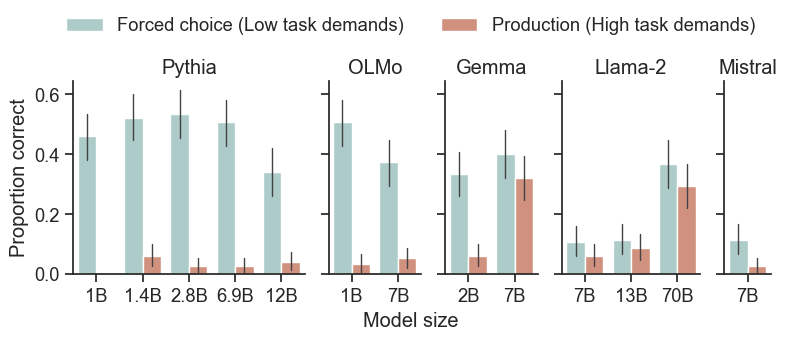

/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_15653/3951775439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wide["model_n_params_log"] = np.log10(df_wide.model_n_params)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an 

Saved figure to ../figures/crt_log_odds_by_size.pdf


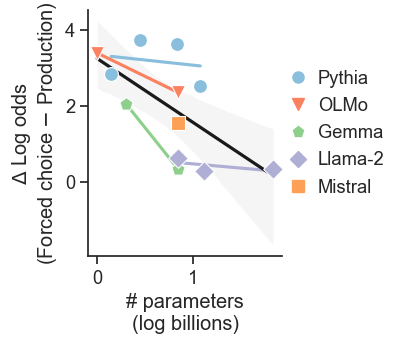

In [11]:
plot_metric_by_eval(df_long, eval_order, "response_correct", "Proportion correct")
render(f"{domain}_accuracy.pdf")
plt.show()
plt.clf()
plot_metric_vs_size(log_odds_diff[np.isfinite(log_odds_diff.log_odds_diff)], "log_odds_diff", label=f"$\\Delta$ Log odds\n({low_demand_method} $-$ {high_demand_method})")
render(f"{domain}_log_odds_by_size.pdf")

# Word prediction

In [12]:
def read_results(task="lambada"): 
    folder=f"../output/{task}"
    files = listdir(folder)
    df_wide = pd.concat([pd.read_csv(f"{folder}/{f}") for f in files if f.endswith(".csv") and "step" not in f])

    # Set some variables.
    df_wide["logprob_diff"] = df_wide["direct_logprob"] - df_wide["meta_logprob"]
    df_wide.model = df_wide.apply(get_pretty_model_name, axis=1)
    df_wide = df_wide[~df_wide.model.isna()]
    df_wide["model_family"] = df_wide.model.apply(get_base_model)
    df_wide["model_n_params"] = df_wide.model.apply(get_n_params, in_billions=True)
    
    # Convert wide to long format.
    data_long = []
    meta_vars = [
        "model", "model_family", "model_n_params", "item_id", "prefix", "final_word"
    ]
    for _, row in df_wide.iterrows():
        for eval_method in ["direct", "meta"]:
            # Copy meta-information about this stimulus item.
            res = {v: row[v] for v in meta_vars}
            # Add specific information about responses.
            res.update({
                "logprob": row[f"{eval_method}_logprob"],
                "eval_method": eval_method,
                "pretty_eval_method": EVAL_MAP[eval_method]
            })
            data_long.append(res)
    df_long = pd.DataFrame(data_long)
    return df_wide, df_long

domain = "lambada"
eval_order = get_eval_order(domain)
low_demand_method, high_demand_method = eval_order
df_wide, df_long = read_results(task=domain)
df_wide.to_csv(f"processed_data/{domain}_wide_size.csv", index=False)
df_long.to_csv(f"processed_data/{domain}_long_size.csv", index=False)
df_wide.head()

,item_id,prefix,final_word,direct_logprob,meta_logprob,kl_divergence,spearman_r_all,spearman_p_all,spearman_r_top100,spearman_p_top100,model,revision,logprob_diff,model_family,model_n_params
0,0,"In my palm is a clear stone, and inside it is ...",signs,-1.358840,-10.091702,0.000134,0.751837,0.0,0.348635,3.783706e-04,Llama-2 7B,NaN,8.732862,Llama-2,7.0
1,1,Give me a minute to change and I'll meet you a...,Shane,-0.811707,-4.322445,0.000127,0.651788,0.0,-0.012553,9.013476e-01,Llama-2 7B,NaN,3.510738,Llama-2,7.0
2,2,"""Only one source I know of that would be likel...",insurance,-0.295797,-2.564898,0.000076,0.676081,0.0,0.234827,1.868596e-02,Llama-2 7B,NaN,2.269100,Llama-2,7.0
3,3,Helen's heart broke a little in the face of Mi...,Helen,-1.033101,-3.462209,0.000059,0.788022,0.0,0.555764,1.947259e-09,Llama-2 7B,NaN,2.429108,Llama-2,7.0
4,4,Preston had been the last person to wear those...,chains,-0.658228,-4.644500,0.000110,0.704897,0.0,0.152847,1.289660e-01,Llama-2 7B,NaN,3.986272,Llama-2,7.0


Saved figure to ../figures/lambada_logprob.pdf


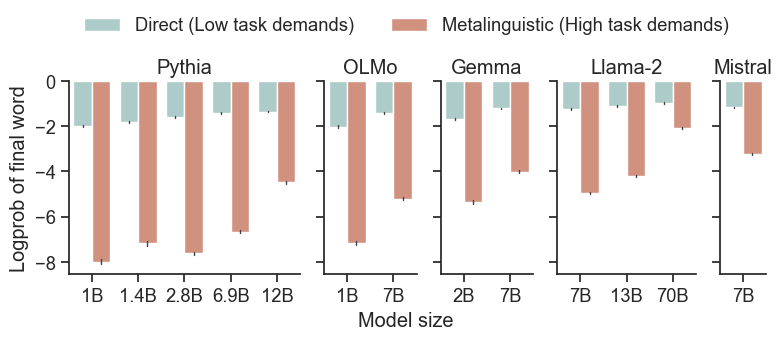

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved figure to ../figures/lambada_logprob_diff_by_size.pdf


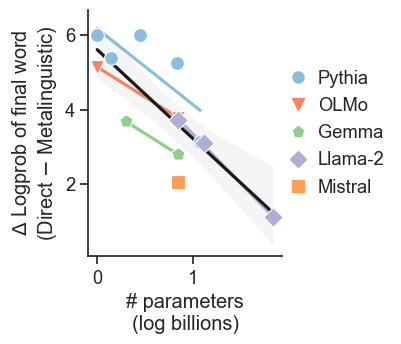

In [13]:
plot_metric_by_eval(df_long, eval_order, "logprob", "Logprob of final word")
render(f"{domain}_logprob.pdf")
plt.show()
plt.clf()
plot_metric_vs_size(df_wide, "logprob_diff", label=f"$\\Delta$ Logprob of final word\n({low_demand_method} $-$ {high_demand_method})")
render(f"{domain}_logprob_diff_by_size.pdf")

# Grammaticality judgment

In [14]:
def read_results(task="blimp"): 
    folder=f"../output/{task}"
    files = listdir(folder)
    df_wide = pd.concat([pd.read_csv(f"{folder}/{f}") for f in files if f.endswith(".csv")])
    df_wide = df_wide[df_wide.model.isin(MODEL_MAP.keys())]
    # Set some variables.
    df_wide["condition"] = condition
    df_wide.model = df_wide.apply(get_pretty_model_name, axis=1)
    df_wide = df_wide[~df_wide.model.isna()]
    df_wide["model_family"] = df_wide.model.apply(get_base_model)
    df_wide["model_n_params"] = df_wide.model.apply(get_n_params)
    
    # Convert wide to long format.
    data_long = []
    if task == "dgl":
        meta_vars = [
            "model", "model_family", "model_n_params", "item_id", "test_item", "phenomenon", "sentence_grammatical", "sentence_ungrammatical"
        ]
    else:
        meta_vars = [
            "model", "model_family", "model_n_params", "item_id", "category_fine", "good_sentence", "bad_sentence"
        ]
    for _, row in df_wide.iterrows():
        for eval_method in ["direct", "meta"]:
            for meta_first_option in ["good", "bad"]:
                # Copy meta-information about this stimulus item.
                res = {v: row[v] for v in meta_vars}
                # Add specific information about responses.
                res.update({
                    "response_correct": row[f"{eval_method}_correct"] if eval_method=="direct" else row[f"meta_{meta_first_option}_correct"], # row["meta_correct_lenient"],
                    "eval_method": eval_method,
                    "pretty_eval_method": EVAL_MAP[eval_method]
                })
                data_long.append(res)
    df_long = pd.DataFrame(data_long)
    return df_wide, df_long

domain = "syntax"
eval_order = get_eval_order(domain)
low_demand_method, high_demand_method = eval_order
wide, long = [], []
for dataset in ["dgl", "blimp"]:
    df_wide, df_long = read_results(task=dataset)
    df_wide["dataset"] = dataset
    df_long["dataset"] = dataset

    if dataset == "dgl":
        # Drop the duplicate Order of Adverbs items.
        df_wide["to_drop"] = (df_wide.phenomenon=="Order of Adjectives")&(df_wide.test_item.isin(["TS 6", "TS 7", "TS 8", "TS 9", "TS 10"]))
        df_long["to_drop"] = (df_long.phenomenon=="Order of Adjectives")&(df_long.test_item.isin(["TS 6", "TS 7", "TS 8", "TS 9", "TS 10"]))
        df_wide = df_wide[~df_wide.to_drop]
        df_long = df_long[~df_long.to_drop]

    wide.append(df_wide)
    long.append(df_long)

df_wide = pd.concat(wide).reset_index().drop(columns=["index"])
df_long = pd.concat(long).reset_index().drop(columns=["index"])
df_wide.to_csv(f"processed_data/{domain}_wide_size.csv", index=False)
df_long.to_csv(f"processed_data/{domain}_long_size.csv", index=False)
df_wide.head()

,item_id,phenomenon,test_item,original_condition,sentence_grammatical,sentence_ungrammatical,condition,direct_sum_logprob_good_sentence,direct_sum_logprob_bad_sentence,direct_correct,...,model_family,model_n_params,dataset,to_drop,good_sentence,bad_sentence,category,category_fine,blimp_UID,blimp_pairID
0,0,Anaphora,TS 1,grammatical,The new executive who oversaw the middle manag...,The new executive who oversaw the middle manag...,crt3,-87.551567,-89.476257,True,...,Llama-2,7.0,dgl,False,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Anaphora,TS 2,grammatical,The popular sheriff who campaigned for the inc...,The popular sheriff who campaigned for the inc...,crt3,-97.004105,-99.776535,True,...,Llama-2,7.0,dgl,False,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Anaphora,TS 3,grammatical,The construction worker who argued with the sh...,The construction worker who argued with the sh...,crt3,-84.040863,-87.020218,True,...,Llama-2,7.0,dgl,False,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Anaphora,TS 4,grammatical,The young caddy who escorted the experienced g...,The young caddy who escorted the experienced g...,crt3,-96.726021,-101.043495,True,...,Llama-2,7.0,dgl,False,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Anaphora,TS 5,grammatical,The police officer who aided the brilliant det...,The police officer who aided the brilliant det...,crt3,-80.271927,-84.614082,True,...,Llama-2,7.0,dgl,False,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
log_odds_diff = compute_log_odds(df_long, eval_order)
log_odds_diff

,model,model_family,model_n_params,log_odds_diff
0,Gemma 2B,Gemma,2.0,1.648001
1,Gemma 7B,Gemma,7.0,0.383956
2,Llama-2 13B,Llama-2,13.0,1.731899
3,Llama-2 70B,Llama-2,70.0,0.049771
4,Llama-2 7B,Llama-2,7.0,1.447034
5,Mistral 7B,Mistral,7.0,0.546117
6,OLMo 1B,OLMo,1.0,1.668527
7,OLMo 7B,OLMo,7.0,1.710465
8,Pythia 1.4B,Pythia,1.4,1.721142
9,Pythia 12B,Pythia,12.0,1.867829


Saved figure to ../figures/syntax_accuracy.pdf


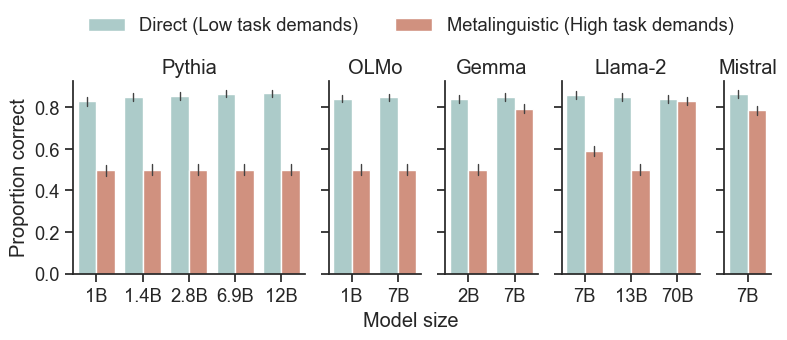

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved figure to ../figures/syntax_log_odds_by_size.pdf


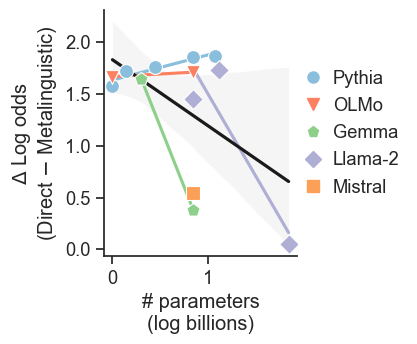

In [16]:
plot_metric_by_eval(df_long, eval_order, "response_correct", "Proportion correct")
render(f"{domain}_accuracy.pdf")
plt.show()
plt.clf()
plot_metric_vs_size(log_odds_diff, "log_odds_diff", label=f"$\\Delta$ Log odds\n({low_demand_method} $-$ {high_demand_method})")
render(f"{domain}_log_odds_by_size.pdf")